In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import astropy.constants as c  
import astropy.units as u  
import simple_slider
from simple_slider import get_surface_density
from log_prob import get_disk_height, params_format
import os

au = c.au.cgs.value

In [54]:
##################
choose = 2
##################
IGD = 0
##################
set_alpha = 1
##################
SV = 0
##################

In [55]:
IGDn = ['','IGD_','IGD_'][IGD]
alphan = ['a-var',''][set_alpha]
addn = "figures\\"+alphan+IGDn
addc = "_C"+str(choose)+['','','_2p','_3p'][gl_n_planets]

In [59]:
samples = np.load('samples\\'+alphan+IGDn+'samples'+addc+'.npy')

flat_samples = samples[300:,:,:].reshape(-1,samples.shape[-1])
Rp_idx = flat_samples[-1] > 1e9
flat_samples_AU = flat_samples.copy()
flat_samples_AU[:,Rp_idx] = flat_samples[:,Rp_idx]/au

percentiles = np.percentile(flat_samples,[16,50,84], axis=0)
mcmc = percentiles[1].tolist()

In [5]:
gl_n_planets = sum(flat_samples_AU[-1] > 90)

labels = ["alpha", "sig0", "p"]

if set_alpha == 1:
    labels = labels[1:]

for i in range(gl_n_planets):
    labels.append(r"$R_{p"+str(i+1)+r"}$"+" [AU]")
    labels.append(r"$\mu_"+str(i+1)+r"$")

In [6]:
if set_alpha == 1:
    def params_format(params, x_data, n_planets):
        params      = np.insert(params,0,gl_alpha)
        alpha       = params[0]
        sig0        = params[1]
        p           = params[2]
        R_p         = []
        mass_ratios = []
        
        for n in range(n_planets):
            R_p         += [params[3 + 2 * n]]
            mass_ratios += [params[4 + 2 * n]]
            
        h_p = get_disk_height(np.array(R_p)).tolist()

        return x_data, alpha, sig0, p, R_p, h_p, mass_ratios

In [7]:
n_points = 500
r_log = np.logspace(np.log10(20), np.log10(400), n_points) * au

In [8]:
switcher = {0:"data_1_planet", 1:"data_one_planet_a1e-2_M1e-3",2:"data_one_planet_a1e-2_M4e-4",
            3:"data_one_planet_a1e-3_M1e-3",4:"data_one_planet_a1e-3_M4e-4", 
            6:"data_planets_scalefree_a1e-2_mu1e-3_r100", 5:"data_planets_scalefree_a1e-2_mu3e-3_r100",
            7:"data_planets_scalefree_a1e-2_mu3e-4_r100", 9:"data_planets_scalefree_a1e-3_mu1e-3_r100",
            8:"data_planets_scalefree_a1e-3_mu3e-3_r100", 10:"data_planets_scalefree_a1e-3_mu3e-4_r100",
            12:"data_planets_scalefree_a1e-4_mu1e-3_r100", 11:"data_planets_scalefree_a1e-4_mu3e-3_r100", 
            13:"data_planets_scalefree_a1e-4_mu3e-4_r100"}

if gl_n_planets == 3:
    data_dir = simple_slider.pkg_resources.resource_filename(simple_slider.__name__, 'data_3_planets')
else:
    data_dir = simple_slider.pkg_resources.resource_filename(simple_slider.__name__, switcher[choose])


r = (np.loadtxt(os.path.join(data_dir, 'radius.dat')))
sigma = np.loadtxt(os.path.join(data_dir, 'sigma_averaged.dat'), unpack=1)[:, -1]
sig = 10.**np.array(np.interp(np.log10(r_log), np.log10(r), np.log10(sigma)))

<IPython.core.display.Javascript object>


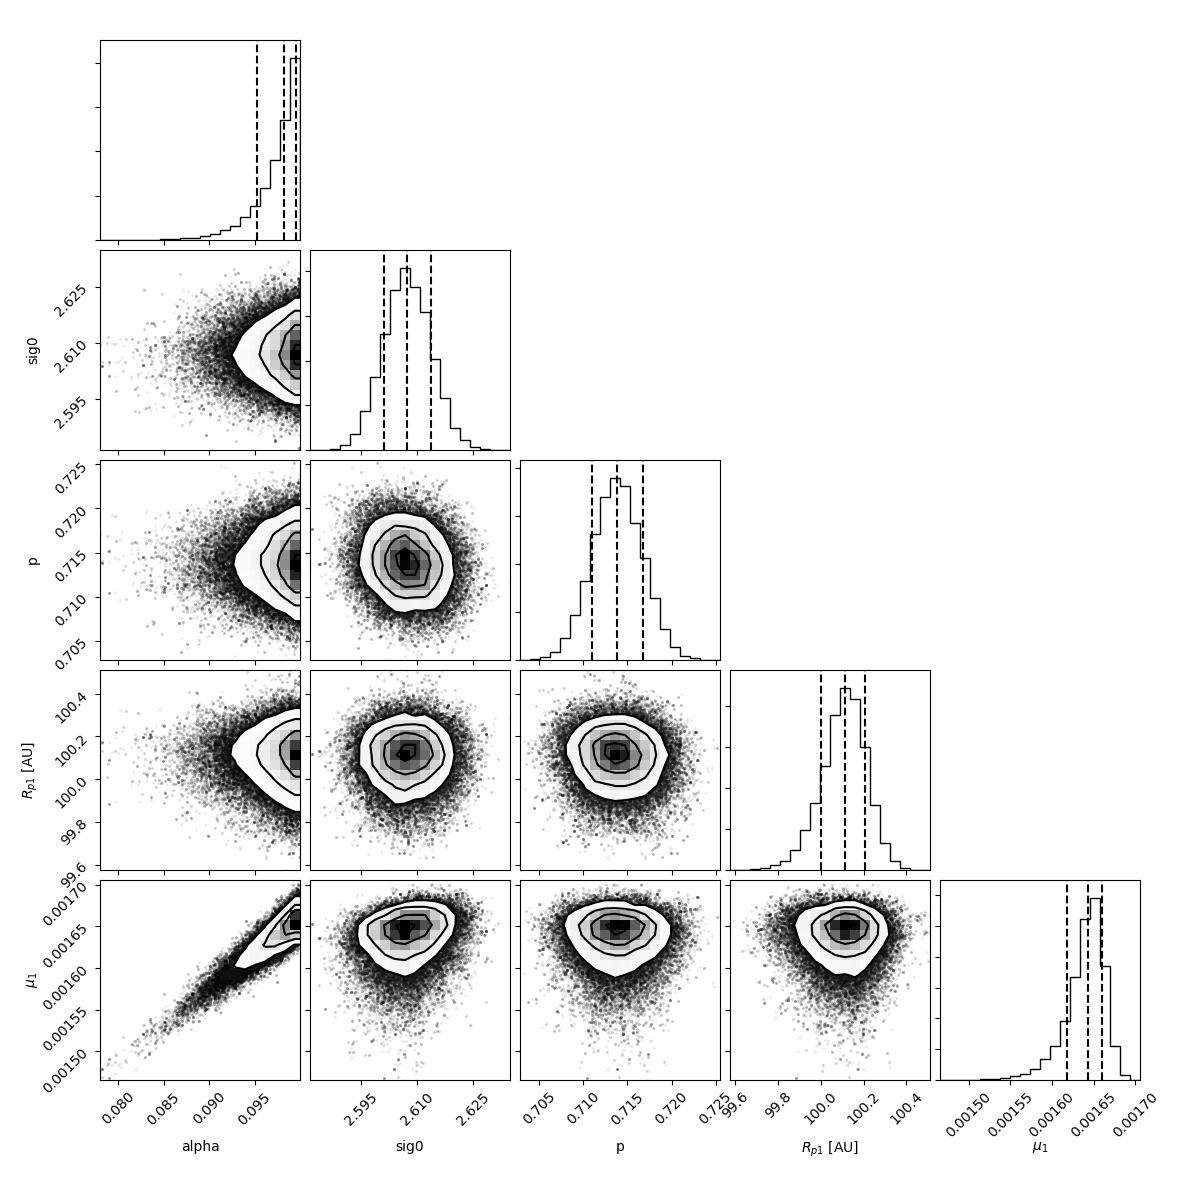

In [9]:
import corner
fig = corner.corner(flat_samples_AU, labels=labels, quantiles=[0.16, 0.5, 0.84]);
#plt.tight_layout(pad=1);
if SV >= 1:
    plt.savefig(addn+'_corner'+addc+'.png',dpi=150)

<IPython.core.display.Javascript object>


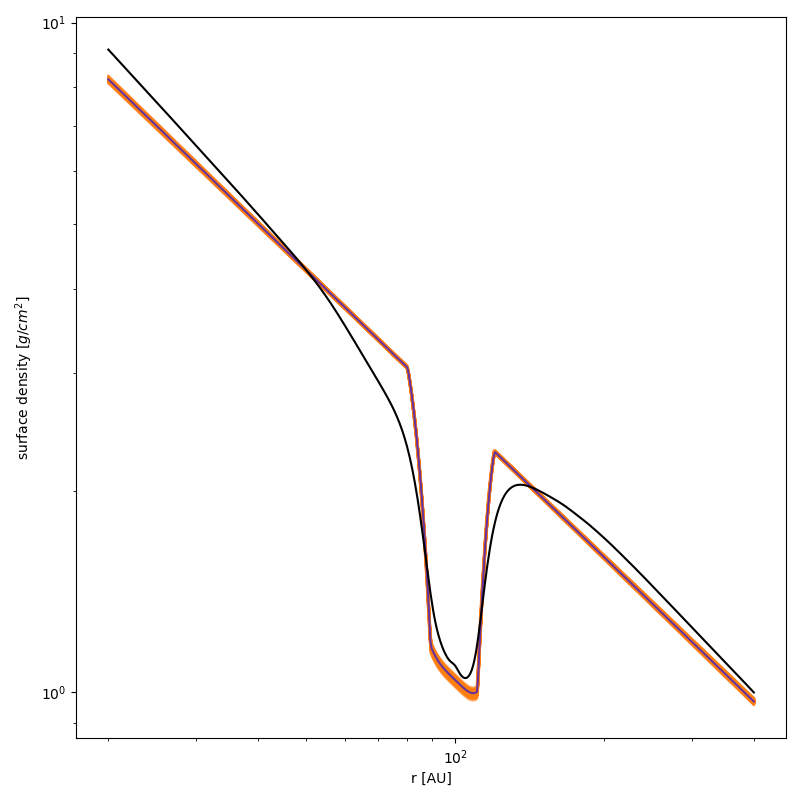

In [10]:
inds = np.random.randint(len(flat_samples), size=1000)
f, ax2 = plt.subplots(figsize=(8, 8))
surf_dens = []
for ind in inds:
    sample = flat_samples[ind]
    x_data, alpha, sig0, p, R_p, h_p, mass_ratios = params_format(sample, r_log, None, gl_n_planets)
    surf_dens += [get_surface_density(x_data, alpha, sig0, p, R_p, h_p, mass_ratios)['sigma']]

surf_dens = np.array(surf_dens).transpose()
ax2.loglog(r_log / au, surf_dens, "C1", alpha=0.1)
x_data, alpha, sig0, p, R_p, h_p, mass_ratios = params_format(np.array(mcmc), r_log, None, gl_n_planets)
ax2.loglog(r_log / au, get_surface_density(x_data, alpha, sig0, p, R_p, h_p, mass_ratios)['sigma'], "b", alpha=0.6)
ax2.loglog(r_log[0:] / au, sig[0:], "k-");
ax2.set_xlabel("r [AU]");
ax2.set_ylabel("surface density ["+r"$g/cm^2$"+"]");
plt.tight_layout(pad=1);
if SV >= 1:
    plt.savefig(addn+'_plot'+addc+'.png',dpi=150)